In [1]:
import pandas as pd
from pysyncon import Dataprep, Synth
from pysyncon.utils import PlaceboTest

In [2]:
df = pd.read_csv("../data/basque.csv")

dataprep = Dataprep(
    foo=df,
    predictors=[
        "school.illit",
        "school.prim",
        "school.med",
        "school.high",
        "school.post.high",
        "invest",
    ],
    predictors_op="mean",
    time_predictors_prior=range(1964, 1970),
    special_predictors=[
        ("gdpcap", range(1960, 1970), "mean"),
        ("sec.agriculture", range(1961, 1970, 2), "mean"),
        ("sec.energy", range(1961, 1970, 2), "mean"),
        ("sec.industry", range(1961, 1970, 2), "mean"),
        ("sec.construction", range(1961, 1970, 2), "mean"),
        ("sec.services.venta", range(1961, 1970, 2), "mean"),
        ("sec.services.nonventa", range(1961, 1970, 2), "mean"),
        ("popdens", [1969], "mean"),
    ],
    dependent="gdpcap",
    unit_variable="regionname",
    time_variable="year",
    treatment_identifier="Basque Country (Pais Vasco)",
    controls_identifier=[
        "Spain (Espana)",
        "Andalucia",
        "Aragon",
        "Principado De Asturias",
        "Baleares (Islas)",
        "Canarias",
        "Cantabria",
        "Castilla Y Leon",
        "Castilla-La Mancha",
        "Cataluna",
        "Comunidad Valenciana",
        "Extremadura",
        "Galicia",
        "Madrid (Comunidad De)",
        "Murcia (Region de)",
        "Navarra (Comunidad Foral De)",
        "Rioja (La)",
    ],
    time_optimize_ssr=range(1960, 1970),
)

synth = Synth()
synth.fit(dataprep=dataprep, optim_method="Nelder-Mead", optim_initial="equal")

In [3]:
synth.weights()

Spain (Espana)                  0.000
Andalucia                       0.000
Aragon                          0.000
Principado De Asturias          0.000
Baleares (Islas)                0.000
Canarias                        0.000
Cantabria                       0.000
Castilla Y Leon                 0.000
Castilla-La Mancha              0.000
Cataluna                        0.851
Comunidad Valenciana            0.000
Extremadura                     0.000
Galicia                         0.000
Madrid (Comunidad De)           0.149
Murcia (Region de)              0.000
Navarra (Comunidad Foral De)    0.000
Rioja (La)                      0.000
Name: weights, dtype: float64

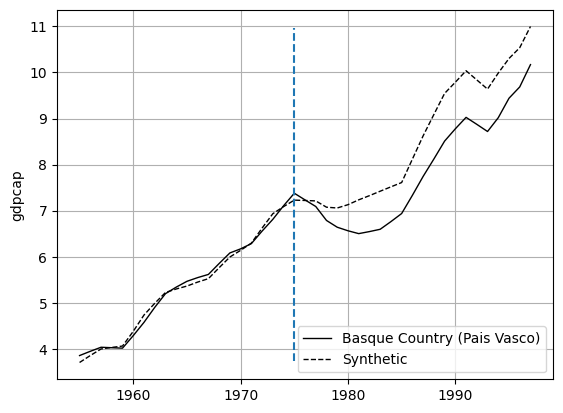

In [4]:
synth.path_plot(time_period=range(1955, 1998), treatment_time=1975)

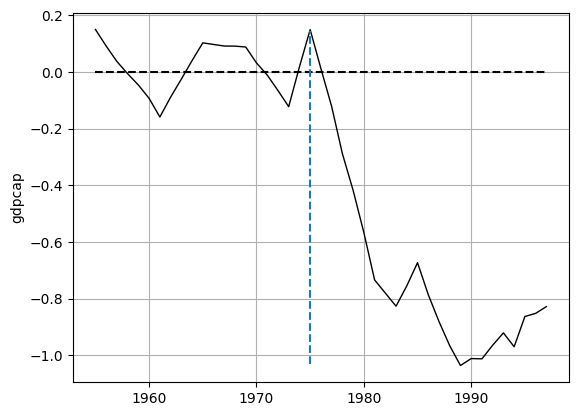

In [5]:
synth.gaps_plot(time_period=range(1955, 1998), treatment_time=1975)

In [6]:
synth.summary()

,V,treated,synthetic,sample mean
school.illit,0.073,39.888,256.337,323.826
school.prim,0.120,1031.742,2730.107,2182.453
school.med,0.003,90.359,223.340,148.864
school.high,0.102,25.728,63.437,47.133
school.post.high,0.011,13.480,36.153,26.163
invest,0.000,24.647,21.583,21.445
special.1.gdpcap,0.117,5.285,5.271,3.584
special.2.sec.agriculture,0.063,6.844,6.179,21.058
special.3.sec.energy,0.155,4.106,2.760,5.252
special.4.sec.industry,0.096,45.082,37.636,22.670


In [7]:
placebo_test = PlaceboTest()
placebo_test.fit(
    dataprep=dataprep,
    scm=synth,
    scm_options={"optim_method": "Nelder-Mead", "optim_initial": "equal"},
)

(1/17) Completed placebo test for Spain (Espana).
(2/17) Completed placebo test for Cataluna.
(3/17) Completed placebo test for Castilla-La Mancha.
(4/17) Completed placebo test for Extremadura.
(5/17) Completed placebo test for Madrid (Comunidad De).
(6/17) Completed placebo test for Aragon.
(7/17) Completed placebo test for Comunidad Valenciana.
(8/17) Completed placebo test for Principado De Asturias.
(9/17) Completed placebo test for Canarias.
(10/17) Completed placebo test for Baleares (Islas).
(11/17) Completed placebo test for Andalucia.
(12/17) Completed placebo test for Cantabria.
(13/17) Completed placebo test for Rioja (La).
(14/17) Completed placebo test for Galicia.
(15/17) Completed placebo test for Castilla Y Leon.
(16/17) Completed placebo test for Murcia (Region de).
(17/17) Completed placebo test for Navarra (Comunidad Foral De).
Calculating treated unit gaps.
Done.


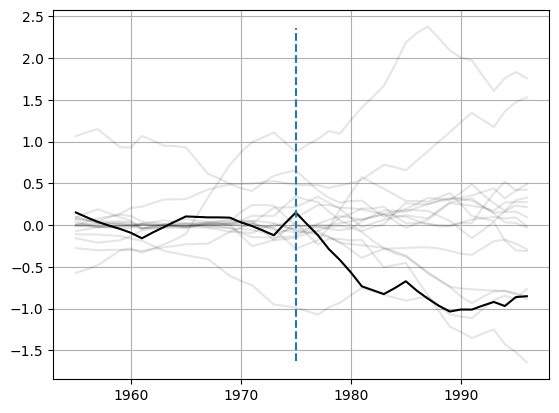

In [8]:
placebo_test.gaps_plot(
    time_period=range(1955, 1998), treatment_time=1975, exclude_units=["Spain (Espana)"]
)

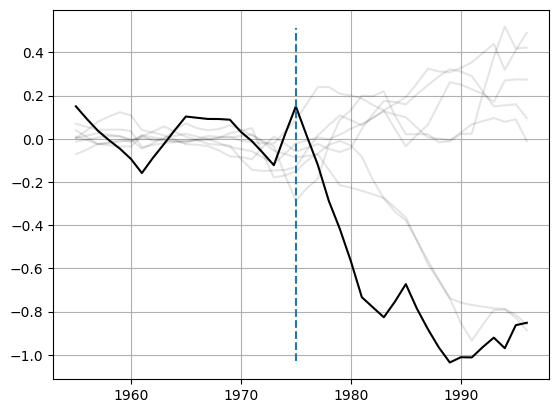

In [9]:
placebo_test.gaps_plot(
    time_period=range(1955, 1998),
    treatment_time=1975,
    exclude_units=["Spain (Espana)"],
    mspe_threshold=1,
)

In [10]:
placebo_test.pvalue(treatment_time=1975)

0.16666666666666666